# SQUANCH demonstration: quantum teleportation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from squanch import *
% matplotlib inline

This Jupyter notebook contains the source code for the [quantum teleportation demonstration](https://att-innovate.github.io/squanch/demos/quantum-teleportation.html). Refer to the documentation for more detailed explanations. 

Quantum teleportation allows two parties that share an entangled pair to transfer a quantum state using classical communication. Conecptually, quantum teleportation is the inverse of superdense coding. The quantum circuit we'll implement in this demonstration is shown below.

![Teleportation circuit](https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Quantum_teleportation_circuit.svg/700px-Quantum_teleportation_circuit.svg.png)

Alice will have the original qubit to be teleported and half of a Bell pair (she sends the other half to Bob prior to the teleportation).

In [2]:
class Alice(Agent):
    '''Alice sends qubits to Bob using a shared Bell pair'''
    
    def distribute_bell_pair(self, a, b):
        # Create a Bell pair and send one particle to Bob
        H(a)
        CNOT(a, b)
        self.qsend(bob, b)

    def teleport(self, q, a):
        # Perform the teleportation
        CNOT(q, a)
        H(q)
        # Tell Bob whether to apply Pauli-X and -Z over classical channel
        bob_should_apply_x = a.measure() # if Bob should apply X
        bob_should_apply_z = q.measure() # if Bob should apply Z
        self.csend(bob, [bob_should_apply_x, bob_should_apply_z])

    def run(self):
        for qsystem in self.stream:
            q, a, b = qsystem.qubits # q is state to teleport, a and b are Bell pair
            self.distribute_bell_pair(a, b)
            self.teleport(q, a)

In [3]:
class Bob(Agent):
    '''Bob receives qubits from Alice and measures the results'''

    def run(self):
        measurement_results = []
        for _ in self.stream:
            # Bob receives a qubit from Alice
            b = self.qrecv(alice) 
            # Bob receives classical instructions from alice
            should_apply_x, should_apply_z = self.crecv(alice)
            if should_apply_x: X(b)
            if should_apply_z: Z(b)
            # Measure the output state
            measurement_results.append(b.measure())
        # Put results in output object
        self.output(measurement_results)

### Simple demonstration

In this demo, we'll teleport a short list of eigenstates with no simulated errors.

In [4]:
# Allocate memory and output structures
mem = Agent.shared_hilbert_space(3, 10) # 3 qubits per trial, 10 trials
out = Agent.shared_output()

# Prepare the initial states
stream = QStream.from_array(mem)
states_to_teleport = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
for state, qsystem in zip(states_to_teleport, stream):
    q = qsystem.qubit(0)
    if state == 1: X(q) # flip the qubits corresponding to 1 states

# Make and connect the agents
alice = Alice(mem, out)
bob = Bob(mem, out)
alice.qconnect(bob) # add a quantum channel
alice.cconnect(bob) # add a classical channel

# Run everything
alice.start()
bob.start()
alice.join()
bob.join()

print("Teleported states {}".format(states_to_teleport))
print("Received states   {}".format(out["Bob"]))

Teleported states [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Received states   [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


### Rotation demonstration

Here we rotate an ensemble of qubits by various angles and compare measured to expected results. Since this example takes longer to run, we'll demonstrate using the `Simulation` module to automatically monitor progress.

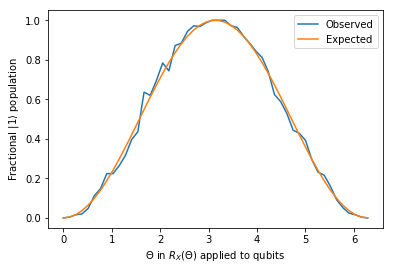

In [5]:
angles = np.linspace(0, 2 * np.pi, 50)  # RX angles to apply
num_trials = 250  # number of trials for each angle

# Allocate memory and output structures
mem = Agent.shared_hilbert_space(3, len(angles) * num_trials)
out = Agent.shared_output()

# Prepare the initial states in the stream
stream = QStream.from_array(mem)
for angle in angles:
    for _ in range(num_trials):
        q, _, _ = stream.next().qubits
        RX(q, angle)

# Make the agents and connect with quantum and classical channels
alice = Alice(mem, out = out)
bob = Bob(mem, out = out)
alice.qconnect(bob)
alice.cconnect(bob)

# Run the simulation
Simulation(alice, bob).run()

# Plot the results
results = np.array(out["Bob"]).reshape((len(angles), num_trials))
observed = np.mean(results, axis = 1)
expected = np.sin(angles / 2) ** 2
plt.plot(angles, observed, label = 'Observed')
plt.plot(angles, expected, label = 'Expected')
plt.legend()
plt.xlabel("$\Theta$ in $R_X(\Theta)$ applied to qubits")
plt.ylabel("Fractional $\left | 1 \\right >$ population")
plt.show()